In [1]:
## Setup
import numpy as np
from src import map_partition, map_transforms

%config InlineBackend.figure_format = 'retina'

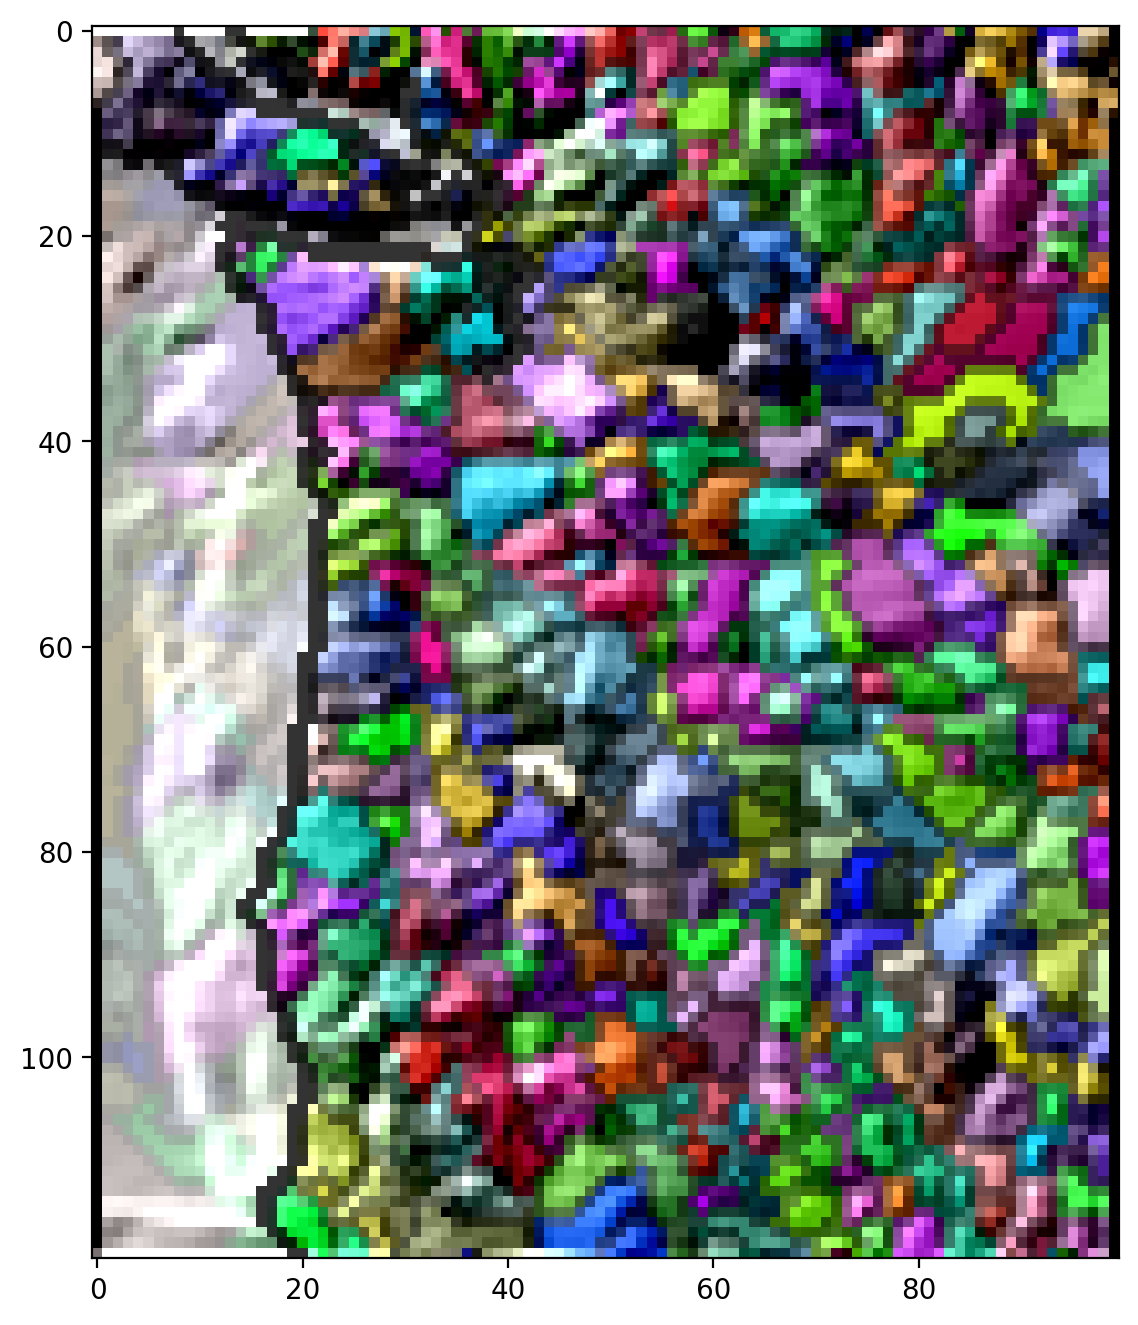

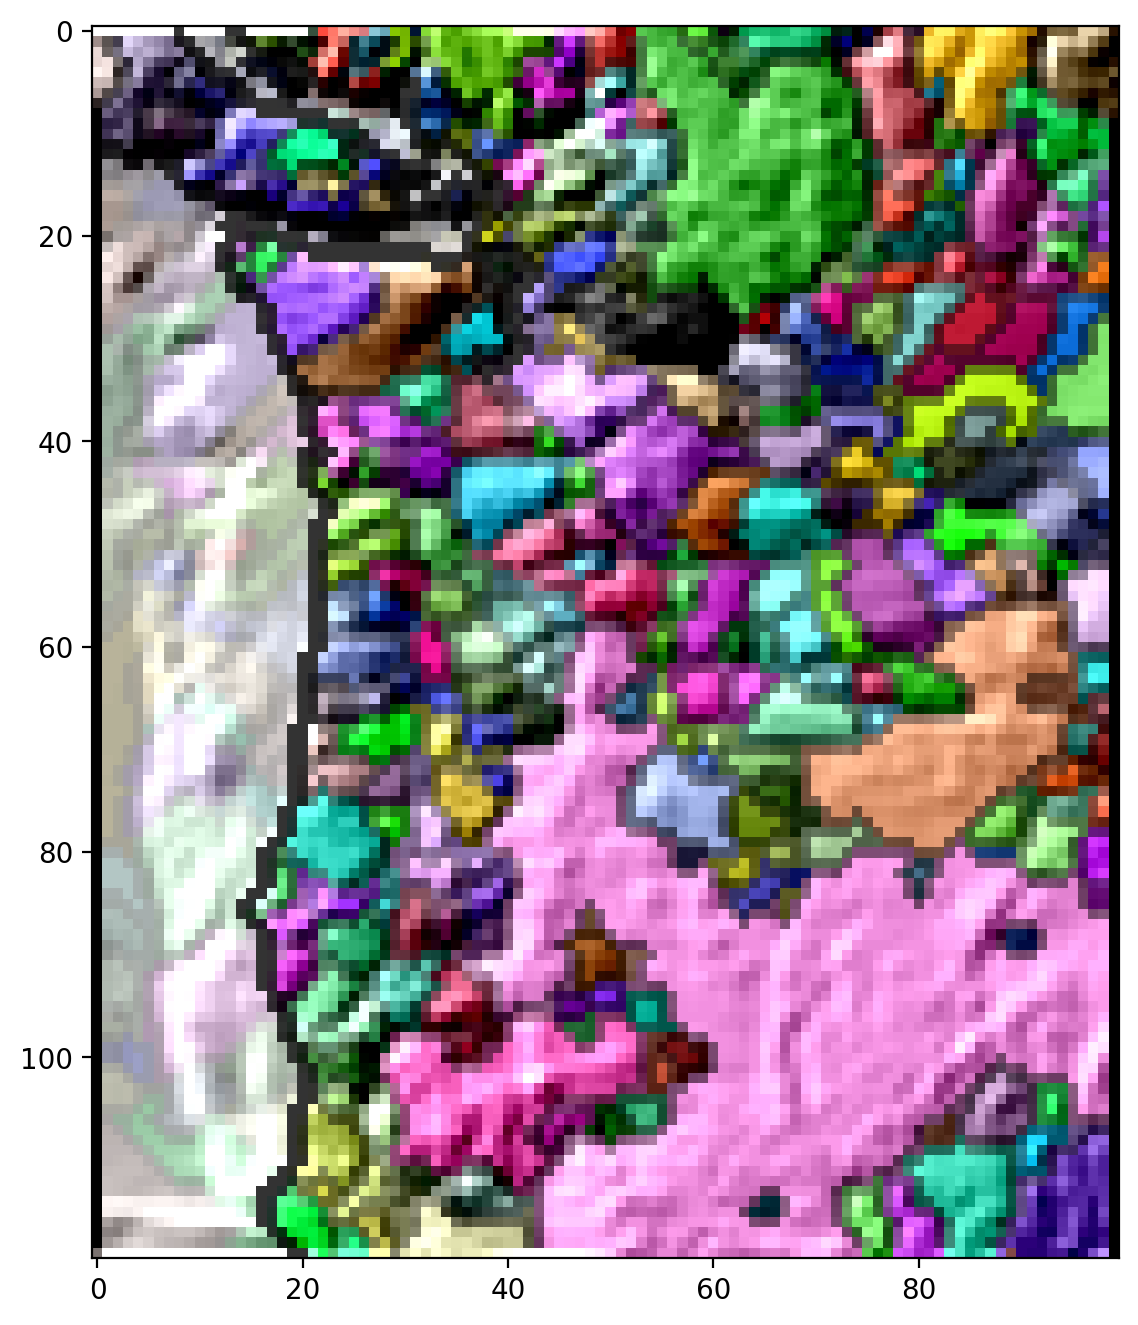

How many things do we have?
     12000 nodes (pixel), points across the map along a 2-dimensional grid
       640 mountains, groupings where all of the nodes in a local area point upward to a single point
               peaks are the highest point in these mountains and are used to index them
       639 merges, times where two mountains are combined, based on the highest point outward from a mountain
               bridges or saddles are the name for the specific points where the merge happens
               ridges are the paths connecting bridges to their peak -- following the highest local nodes

Let's now think of how mountains intersect and are combined along the bridge nodes
Think of the intersections like V shapes. greater peak -> bridge -> lesser peak -- are these Vs large? Are they partially underwater?

Do the ridges in the connections cross the water line / interface? Considering what is above water (L) or below (S)?
Interface Pattern : Local  Divisions
LLL               :   

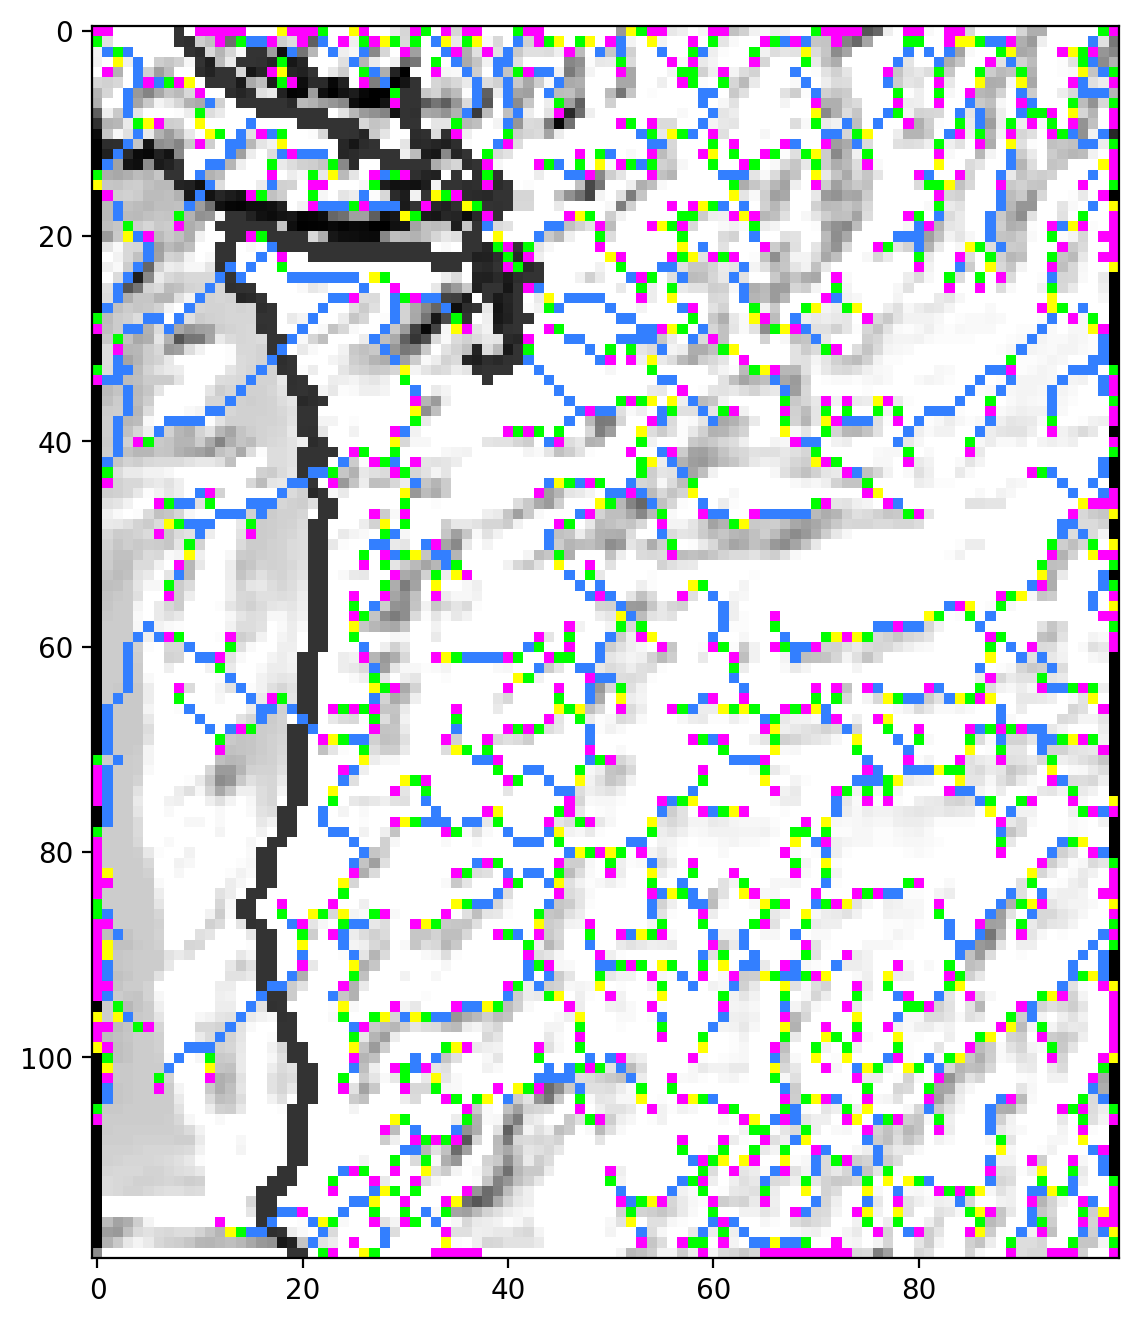

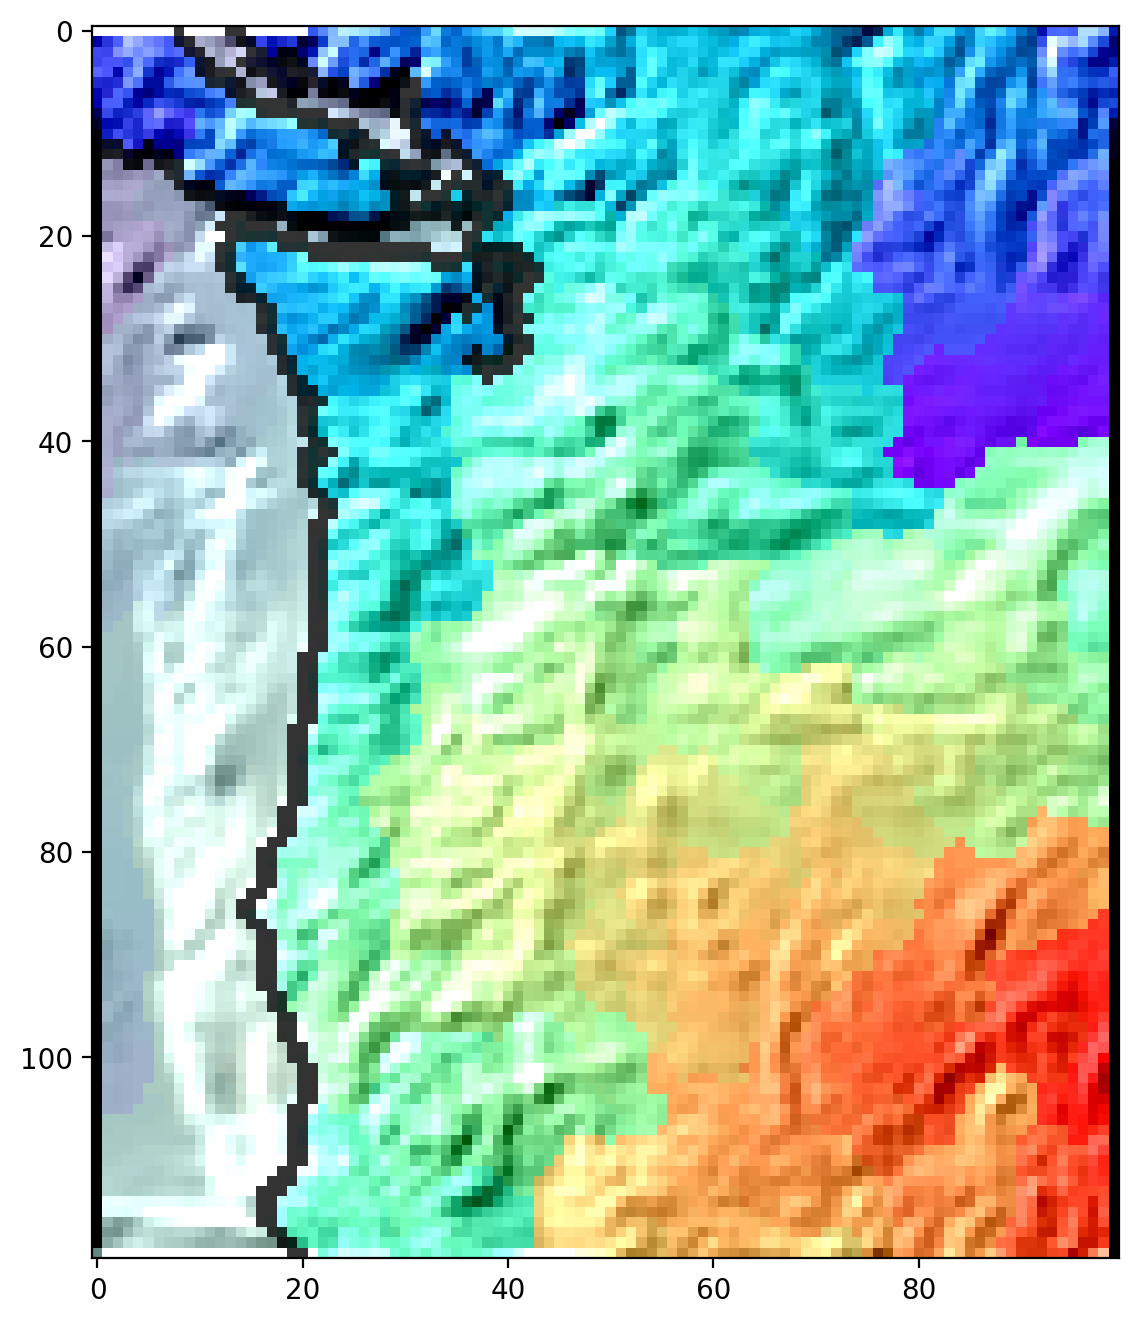

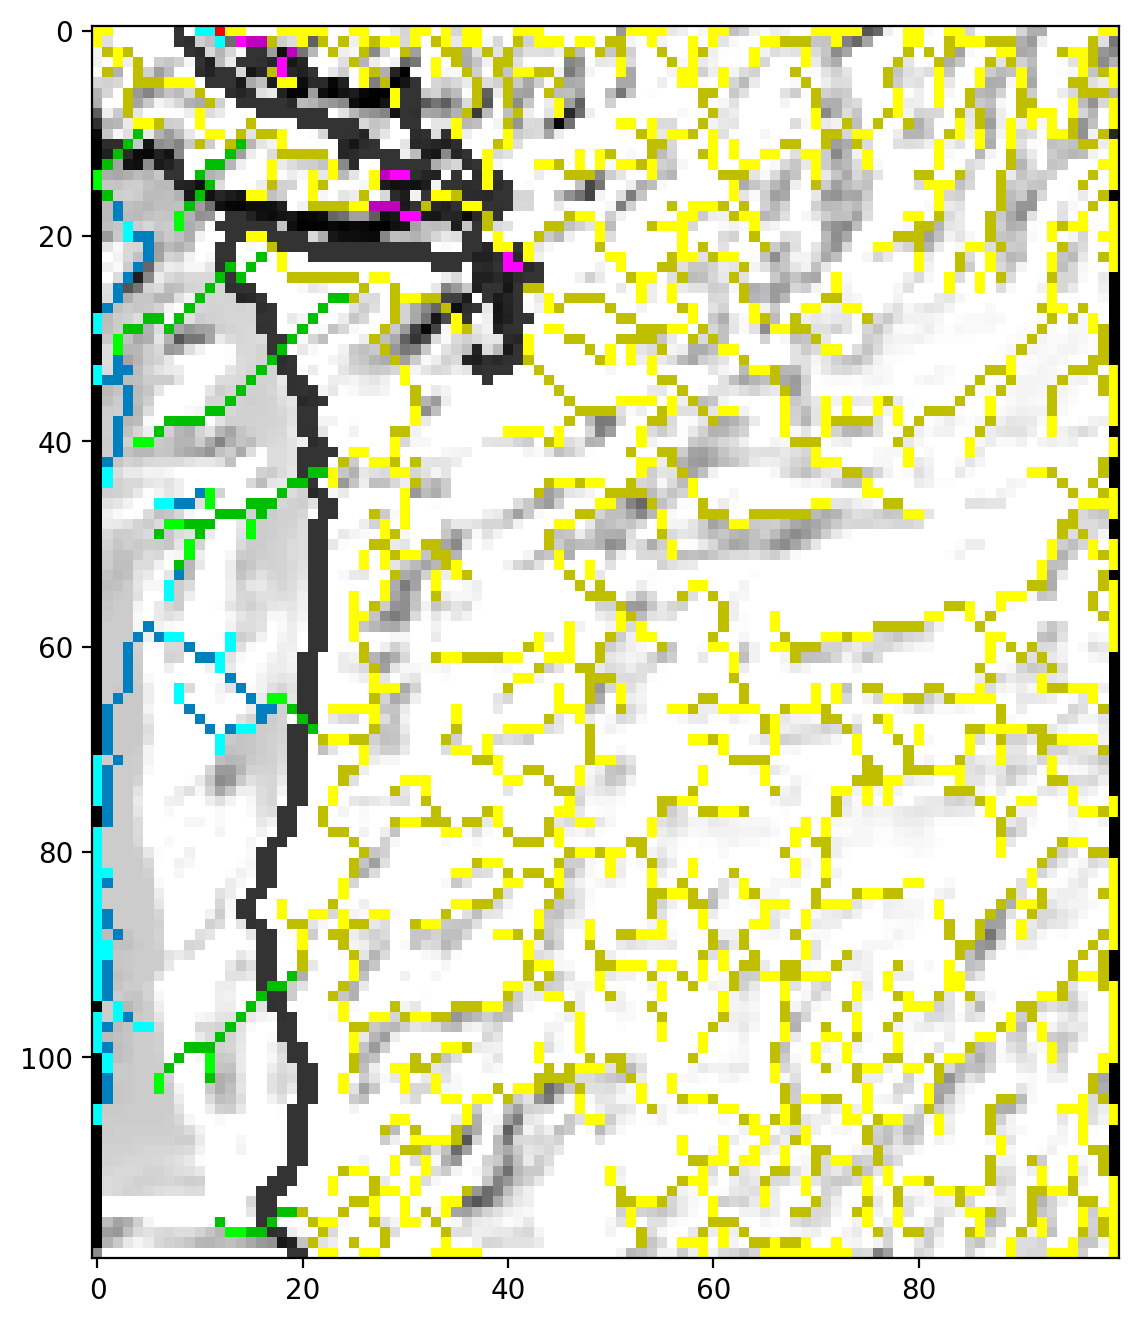

mountains with   1 connection :    214
mountains with   2 connections:    265
mountains with 3-5 connections:    159
mountains with  >5 connections:      2

tbi_5min_cascadia_islands.png


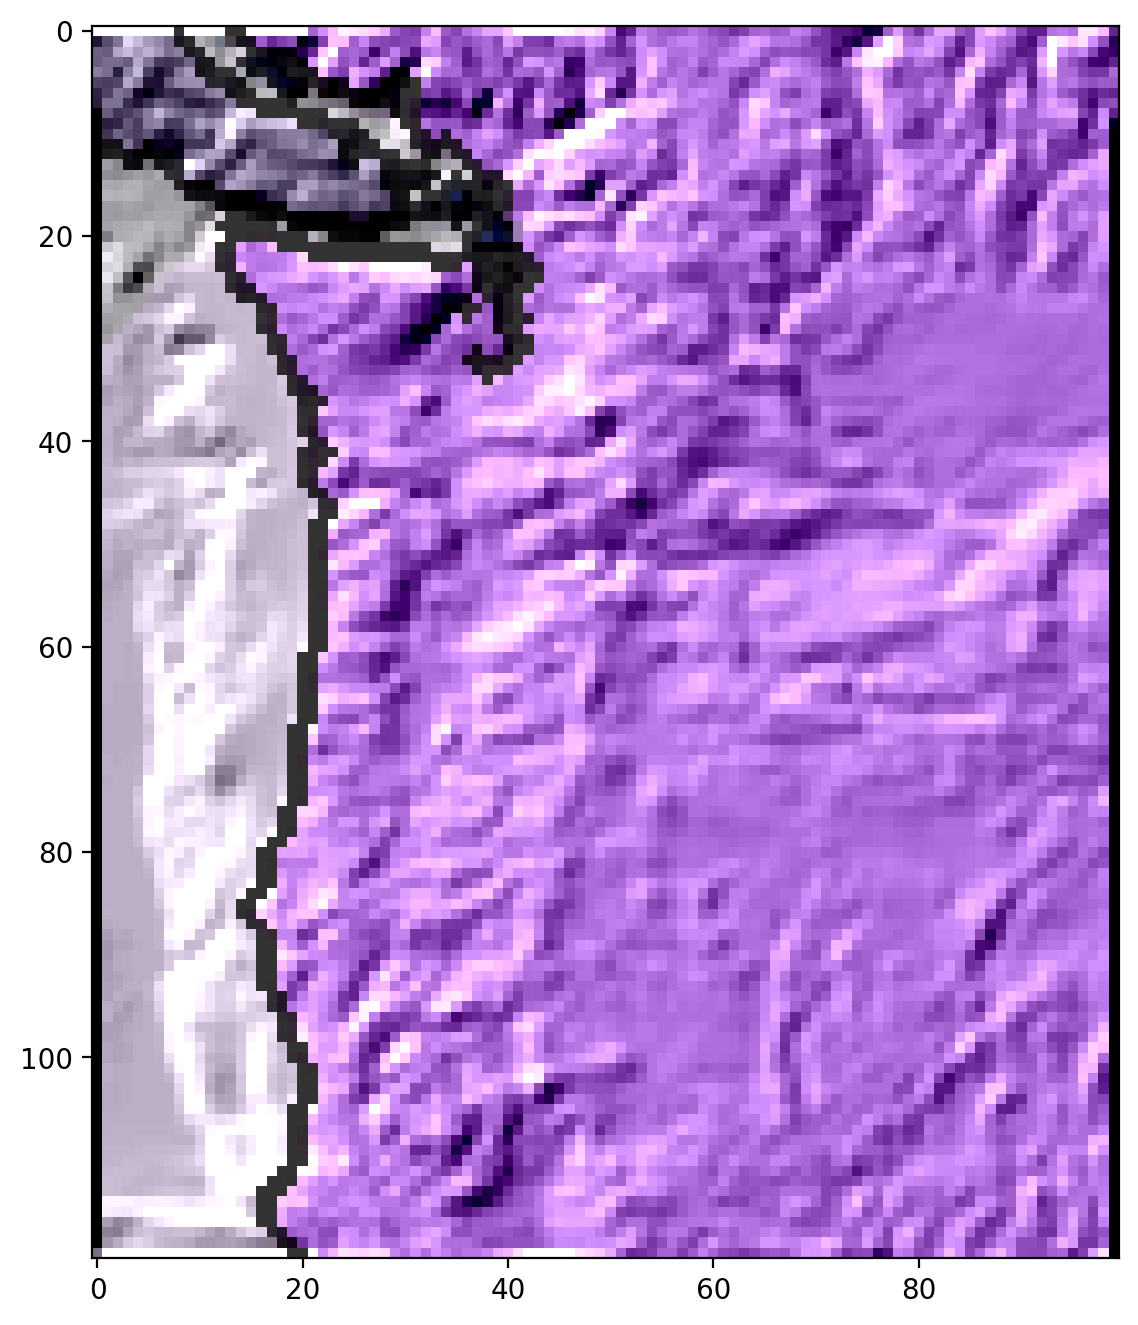

In [2]:
LP = map_partition.LocalePartition(dataset='TBI', region='cascadia', minutes_per_node=5, image_folder='img/04/', flow_direction='up')
LP.computeStandardDivisionInformation(print_stats=True, draw_all_images=True)
nodes_division_sealevel = LP.drawDivisionsAcrossSeaLevel(print_filenames=True, display_images=True, final_analysis_filename=True)

tbi_5min_cascadia_mountain_ranges-separating_merges_with_bridge_dist_1000.png


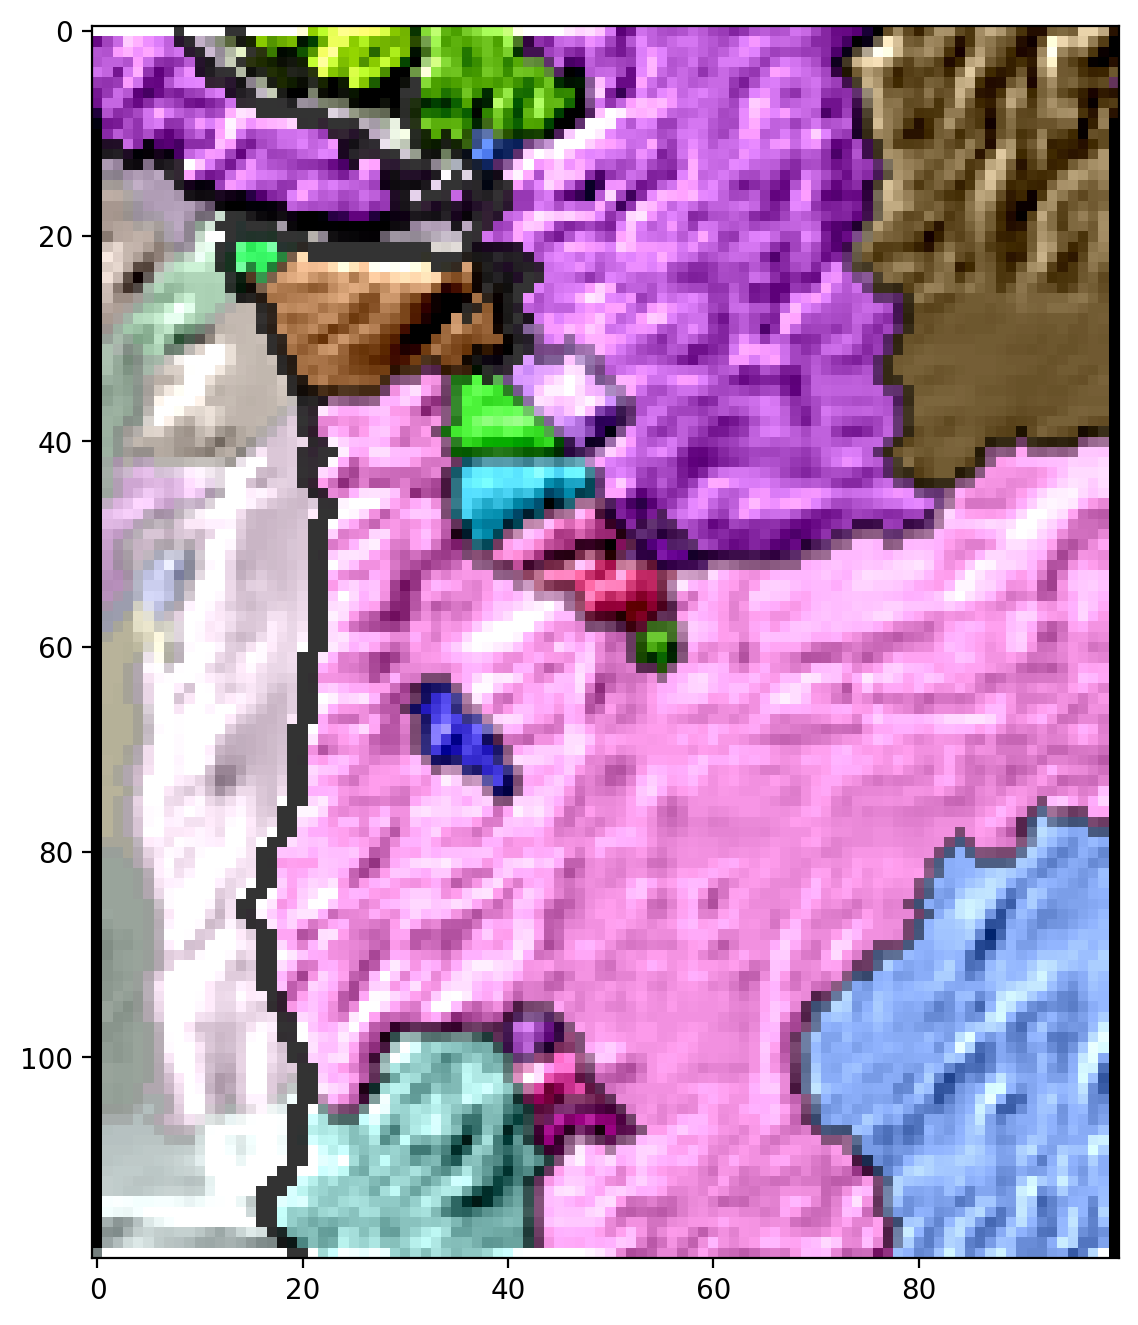

In [3]:
# Large bridge gaps
#
# While we were merging nodes we recorded the distance between the valley floor and the immediately adjacent peak.
# Splitting up mountain ranges by ignoring combinations across large valleys seems to make sense, let's give it a try
#
# We'll copy a lot of this function from LocalePartition.drawDivisionsAcrossSeaLevel

def drawPartitionInLargeBridgeDifferences(self, bridge_dist, print_filenames=False, display_images=False, final_analysis_filename=False):
    nodes_locale = self.maps['locale'].getDataFlat() # Use this to color the whole locales by the new division
    nodes_value = self.maps['elevation'].getDataFlat() # Use this to see if a extremum is above or below water
    locales_adjacency_list = self.getLocaleAdjacencyList() # start from scratch because we will actively edit it

    # The data we are computing
    node_global_extremum_index = np.argsort(nodes_value)[0] # This is the parent locale to all others
    nodes_division = np.full(self.n_nodes, node_global_extremum_index) # Start with everything being unified under this peak
    n_locales = len(locales_adjacency_list)

    # Iterate over the merge
    for merge in self.merges:
        # Only split up merges in the list of interfaces to split up
        # Note distance_between_bridge_and_hi_division_extremum doesn't work since we'd need to re-compute that
        #   after each partition
        if merge['distance_between_bridge_and_hi_local_extremum'] < bridge_dist:
            continue

        # Break the adjacency
        m1 = merge['locale_lo']
        m2 = merge['locale_hi']
        locales_adjacency_list[m1] = np.setdiff1d(locales_adjacency_list[m1], [m2])
        locales_adjacency_list[m2] = np.setdiff1d(locales_adjacency_list[m2], [m1])

        # Compute the new groups (using stand-in values for the highest extremum)
        # Note: We are doing double work since we don't know which side the overall extremum is on
        nodes_division = self.getNodesDivisionAfterPartition(nodes_division, m1, locales_adjacency_list, nodes_value)
        nodes_division = self.getNodesDivisionAfterPartition(nodes_division, m2, locales_adjacency_list, nodes_value)

    # Finally expand the division color to all nodes
    for locale_index in np.arange(len(nodes_locale)):
        nodes_division[nodes_locale == locale_index] = nodes_division[locale_index]

    map_division = self.maps['locale'].newChildInstance({'values': 'division'}, nodes_division)
    map_division_border = map_transforms.getBorder(map_division, 1)

    layer_names = [
        self.labels['division'] + 's',
        'separating_merges_with_bridge_dist_{:.0f}'.format(bridge_dist),
    ]
    if final_analysis_filename:
        # For the images at the end of the analysis
        layer_names = [self.labels['division'] + 's']

    drawing = self.getImageBase( 
             nodes_bg_value=nodes_division,
             nodes_border=map_division_border.getDataFlat()) \
        .overrideLayerNames(layer_names).save()

    if print_filenames:
        print(drawing.getFilename())
    if display_images:
        drawing.display().final()

drawPartitionInLargeBridgeDifferences(LP, bridge_dist=1000, print_filenames=True, display_images=True)


tbi_1min_cascadia_mountain_ranges-separating_merges_with_bridge_dist_1000.png


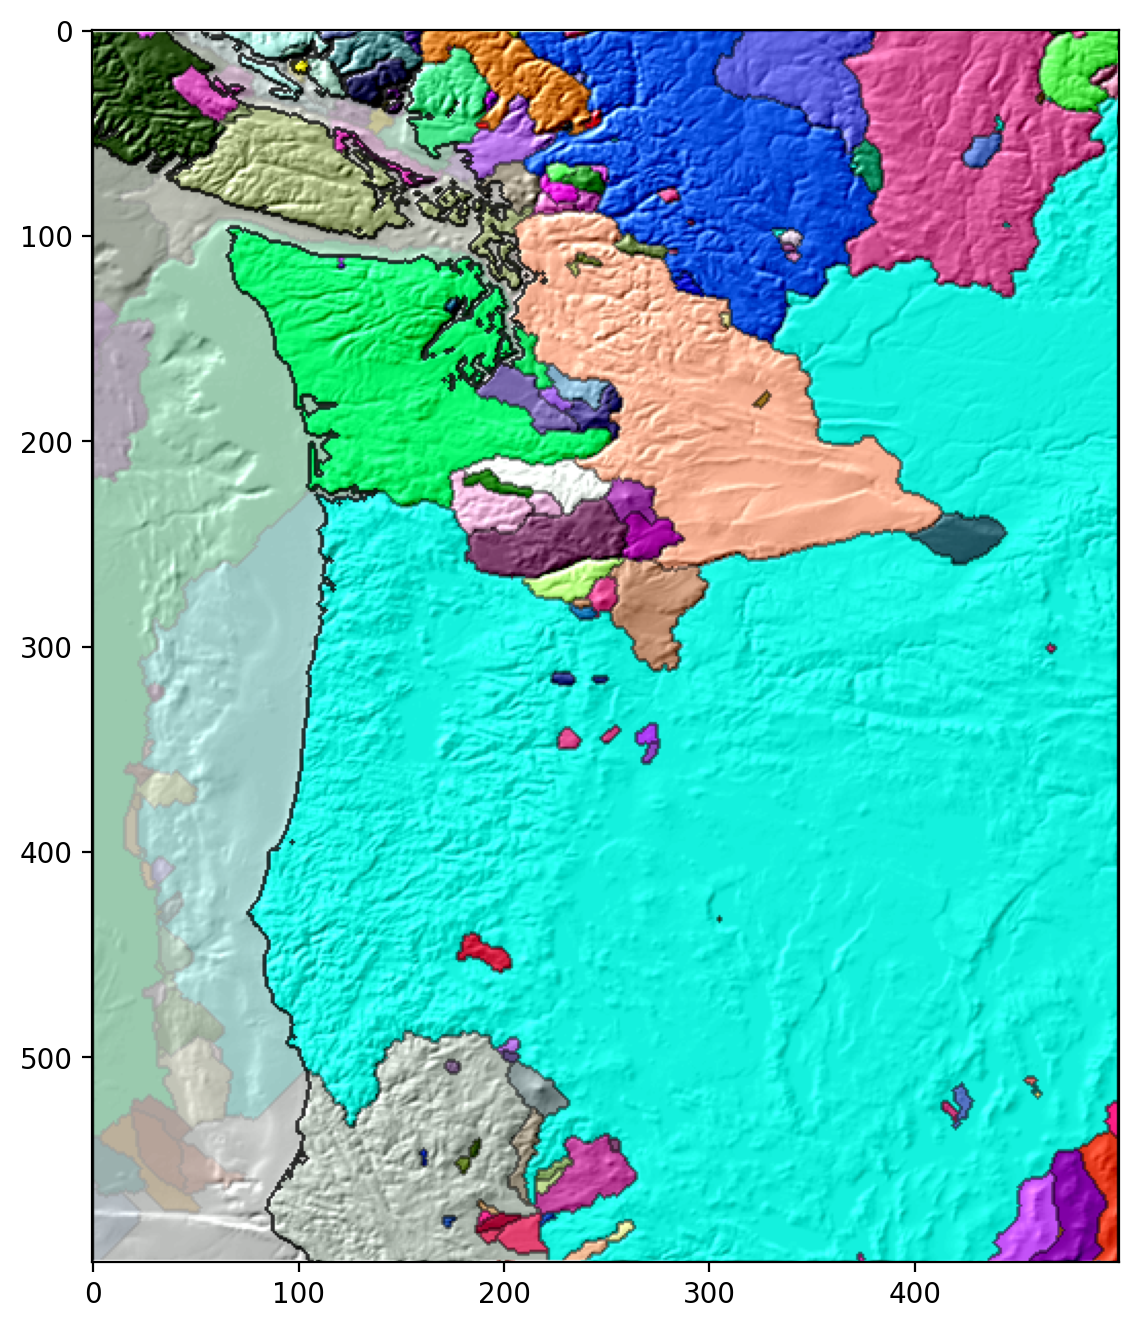

In [4]:
# Hmmm, that does not look quite right. Let's try it out on the finer dataset & the watersheds

LP2 = map_partition.LocalePartition(dataset='TBI', region='cascadia', minutes_per_node=1, image_folder='img/04/', flow_direction='up')
LP2.computeStandardDivisionInformation(print_stats=False, draw_all_images=False)
drawPartitionInLargeBridgeDifferences(LP2, bridge_dist=1000, print_filenames=True, display_images=True)

# LP3 = map_partition.LocalePartition(dataset='TBI', region='cascadia', minutes_per_node=5, image_folder='img/04/', flow_direction='down')
# LP3.computeStandardDivisionInformation(print_stats=False, draw_all_images=False)
# drawPartitionInLargeBridgeDifferences(LP3, bridge_dist=1000, print_filenames=True, display_images=True)

# LP4 = map_partition.LocalePartition(dataset='TBI', region='cascadia', minutes_per_node=1, image_folder='img/04/', flow_direction='down')
# LP4.computeStandardDivisionInformation(print_stats=False, draw_all_images=False)
# drawPartitionInLargeBridgeDifferences(LP4, bridge_dist=1000, print_filenames=True, display_images=True)


### Analysis for splitting on the bridge valley/cliff size

This ended up failing but also still being interesting.

Now we've standardized it, we can compare the results of what things look like if we separate different criteria based on the interface (sorry, interface is the best word I could come up with for when lines cross the sea & land).

Overall I think there are cool details we can see separating mountain ranges based on "LSL & LSS" and "LSL & LLL" merges. The maps don't quite add up to mountain ranges -- so let's continue interating.

| Flow Direction | Image & Description | Next Steps |
| --- | --- | --- |
| Up: Mountain Ranges | ![Mountain ranges](img/04/tbi_1min_cascadia_mountain_ranges-separating_merges_with_bridge_dist_1000.png) <br /> We can see clear divisions like the Columbia River. We see sensible-ish ranges like the Kalamath mountains in the south, Olympic Peninsula, and some divisions in the northern cascades. However, the large cascade volcanes (Rainier, Adams, St Helens, Hood) are isolated to their own groups and many smaller ones are also as well, but not predictably. Furthermore, the Oregon coastal range + oregon cascades + high desert + WA scablands are still groupped. | I think this shows the challenge in determining mountain ranges. If we zoom in in Western Oregon there is no clear break between the mountains but when we zoom out we see the two lines on either side of the Willamette valley. The problem is that when the Willamette valley gives way to the hills around them there is not a clear way to break it up. <br /><br /> For next steps, we will certainly want to include a criteria of how big of an area we actually split in that split -- or also try out the algorithm with the full valley distance. (eg. Mount Rainer -> Columbia River -> Mt Hood) rather than just the local valleys. |
| Down: Watersheds) | ![Watersheds](img/04/tbi_1min_cascadia_watersheds-separating_merges_with_bridge_dist_1000.png) <br /> The Columbia watershed stays distinct, as well as the Kalamath and many smaller coastal ones. Interestingly, the Puget Sound watershed is grouped together. Some random basins are separate in the mountains (potentially locally endoheric basins though, since the bridges may be too steep). Interestingly, you can almost clearly make out the political division of Tillamook county. | I think the main place where deep bridges were partitions were if they fall off the continental shelf. That's an interesting way to think about breaking up the coastal rivers that are almost practically part of the same place. However, it's still a bit arbitrary. <br /><br /> One thing I didn't realize is that how rivers continue INTO the ocean -- at the mouth of the Columbia river you can see the river punch into the continental shelf and erode the shelf, leaving a record of where this river exits the continent. It's a known fact that the force of the river does continue downward into the ocean. However, in this case the underwater continuation is joined with the Puget Sound, darn. <br /><br /> Next steps I'd be interested in going the breakdown as mentioned above. 

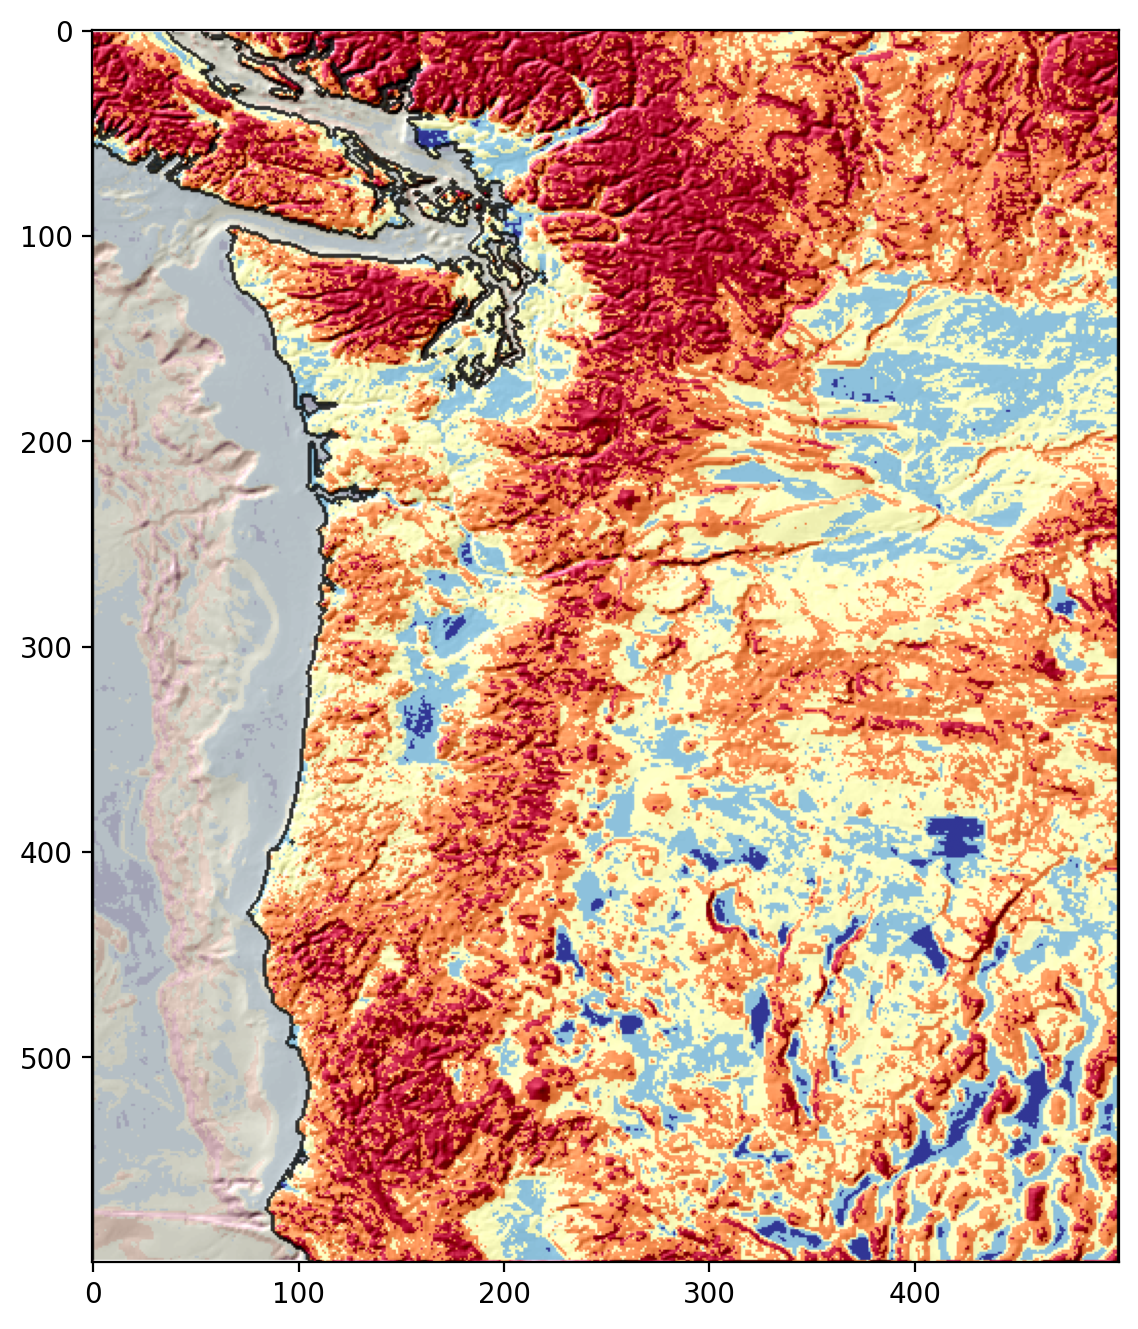

In [5]:
## Ruggedness
# Before we try to divide the map again, let's compute how rugged each node is

def getNodesRuggedness(self, display_image=True, save_image=True):
    grid_value = self.maps['elevation'].getDataMatrix()
    grid_ruggedness = np.zeros(grid_value.shape)

    for x in range(-1, 2):
        for y in range(-1, 2):
            if not (x == 0 and y == 0):
                distance = (x**2 + y**2) ** 0.5
                grid_ruggedness += np.abs(grid_value - np.roll(np.roll(grid_value, y, 1), x, 0)) / distance
    
    nodes_ruggedness = grid_ruggedness.flatten()
    nodes_ruggedness_grouped = np.zeros(self.maps['elevation'].getNumNodes(), dtype=np.int8)
    nodes_ruggedness_grouped[nodes_ruggedness > 10] = 1
    nodes_ruggedness_grouped[nodes_ruggedness > 100] = 2
    nodes_ruggedness_grouped[nodes_ruggedness > 400] = 3
    nodes_ruggedness_grouped[nodes_ruggedness > 1000] = 4

    map_ruggedness_grouped = self.maps['elevation'].newChildInstance({'values': 'ruggedness'}, nodes_ruggedness_grouped)
    map_ruggedness_border = map_transforms.getBorder(map_ruggedness_grouped, 1)

    drawing = self.getImageBase(
            nodes_bg_value=-nodes_ruggedness_grouped, 
            nodes_bg_colormap='diverge') \
        .overrideLayerNames(['ruggedness'])
    
    if display_image:
        drawing.display()
    drawing.save().final()
    
getNodesRuggedness(LP2)

# Uncomment this to draw it for a bunch more regions
# for region in ['hawaii', 'cascadia', 'alps', 'germany', 'korea', 'myanmar']:
#     LP = map_partition.LocalePartition(dataset='TBI', region=region, minutes_per_node=1, image_folder='img/04/', flow_direction='up')
#     LP.computeStandardDivisionInformation(print_stats=False, draw_all_images=False)
#     getNodesRuggedness(LP, display_image=False)